In [141]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from scipy.spatial import distance
import matplotlib.pyplot as plt
ep=10
import math
import itertools
import os.path

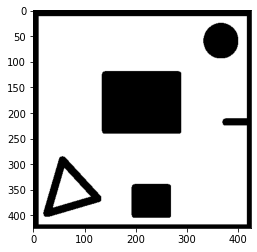

In [121]:
#assuming the robot is circular in shape
def configspace(img,L):
    circle=np.zeros([2*L+2,2*L+2,3],dtype=np.uint8)
    circle=cv2.circle(circle,(L,L), L+1, (255,255,255), -1)
    struct_element=cv2.cvtColor(circle, cv2.COLOR_BGR2GRAY)
    struct_element[struct_element>0]=1
    closing = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct_element)
    dilation = cv2.erode(img,struct_element,iterations = 1)
    return dilation

img=cv2.imread("/content/sq_maze.png")
# plt.imshow(img.astype(np.uint8))
dilate=configspace(img, 5)
plt.imshow((dilate).astype(np.uint8))

In [ ]:
def rrt_holon_recur(img, t1, t2,cnt = 0):
    gra = {(x,y) : [] for x in range(img.shape[0]) for y in range(img.shape[1])}
    vis = {(x,y) : 0 for x in range(img.shape[0]) for y in range(img.shape[1])}
    ep=10
#     cnt += 1
    if cnt == 1000 :
        return False,[]
    gra = {(x,y) : [] for x in range(img.shape[0]) for y in range(img.shape[1])}
    config=img #updated obstacles
    available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
    qRand = available[np.random.randint(0,len(available))]
    calc = distance.cdist(t1,[qRand])
    qNear = t1[np.argmin(calc)]
    u = qRand - qNear
#     if np.linalg.norm(u) == 0: continue
    v = u / np.linalg.norm(u)
    qNew = qNear + ep*v
    qNew = np.asarray(qNew,dtype=np.int64) 
    imgcpy = config.copy()
    prevobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
    cv2.line(imgcpy,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
    newobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
    if prevobs == newobs:
        cv2.line(config,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
        tem = gra[(qNear[0],qNear[1])]
        tem.append([qNear[0],qNear[1],qNew[0],qNew[1]])
        gra[(qNew[0],qNew[1])] = tem
        t1 = np.vstack([t1,qNew])
#         print(qNew)
#             available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
    plt.imshow(config.astype(np.uint8))
    if np.min(distance.cdist(t1,t2)) < 10: 
#         print("tem")
        gra[(qNew[0],qNew[1])].append([qNew[0],qNew[1],t2[0][0],t2[0][1]])
        return True,[[qNew[0],qNew[1],t2[0][0],t2[0][1]],[qNear[0],qNear[1],qNew[0],qNew[1]]]
    tem,pat = rrt_holon_recur(config,t1,t2,cnt)
    if tem == True:
        pat.append([qNear[0],qNear[1],qNew[0],qNew[1]])
        return True,pat
    return False,pat
#             break
        

In [ ]:
def dfs(cur,des,path):
    global gra
    global vis
    global opt
    path.append(cur)
    if cur == des:
        opt = path.copy()
        return path
    vis[cur] = 1
    if len(gra[cur]) > 0:
        for pt in gra[cur]:
            if (vis[pt]).all() == 0:
                dfs(pt,des,path)       
    path.pop()

In [142]:
def rrt_holon(img, t1, t2):
    ep=10
    global gra
    global vis
    global temp
    gra = {(x,y) : [] for x in range(img.shape[0]) for y in range(img.shape[1])}
    vis = {(x,y) : 0 for x in range(img.shape[0]) for y in range(img.shape[1])}
    config=configspace(img,5) #updated obstacles
    path = []
    for i in range(100):
        available = np.array(np.where((config == [255, 255, 255]).all(axis = 2))).T
        qRand = available[np.random.randint(0,len(available))]
        img[qRand[0]][qRand[1]]==[0,255,0]
        temp.append(qRand)
        calc = distance.cdist(t1,[qRand])
        qNear = t1[np.argmin(calc)]
        u = qRand - qNear
        if np.linalg.norm(u) == 0: continue
        v = u / np.linalg.norm(u)
        qNew = qNear + ep*v
        qNew = np.asarray(qNew,dtype=np.int64) 
        if(i%100==0):
            print("i",i)
        if(qNew[0]<0 or qNew[0]>img.shape[1] or qNew[1]<0 or qNew[1]>img.shape[0]):
            continue
        
        imgcpy = config.copy()
        prevobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
        cv2.line(imgcpy,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
        newobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
        if prevobs == newobs:
            cv2.line(img,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
            path.append([qNear[0],qNear[1],qNew[0],qNew[1]])
            t1 = np.vstack([t1,qNew])
            

        # plt.savefig("/content/outputs")
        direc = '/content/outputs/'
        cv2.imwrite(os.path.join(path , f'waka_{i}.jpg'), img)
        # cv2_imshow(img)
        plt.imshow(img.astype(np.uint8))
        if np.min(distance.cdist(t1,t2)) < 10 : 
            path.append([qNew[0],qNew[1],t2[0][0],t2[0][1]])
            print("destination reached")
            return path        

In [143]:
t1 = [[30,30]]
t2 = [[400,400]]
t1 = np.asarray(t1)
t2 = np.asarray(t2)
# img = 255*np.ones((200,200,3))
img = cv2.imread("/content/sq_maze.png")
cv2.circle(img,tuple(t2[0]), 5, (255,0,0), -1)
gra = {}
vis = {}
opt = []
temp=[]
path = rrt_holon(img,t1,t2)
plt.imshow(img)

i 0


TypeError: ignored

i 0
i 100
i 200
i 300
i 400
i 500
i 600
i 700
i 800
i 900
destination reached


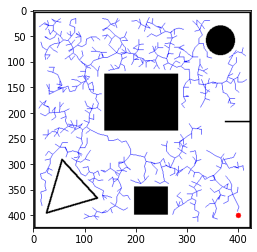

In [130]:
t1 = [[30,30]]
t2 = [[400,400]]
t1 = np.asarray(t1)
t2 = np.asarray(t2)
# img = 255*np.ones((200,200,3))
img = cv2.imread("/content/sq_maze.png")
cv2.circle(img,tuple(t2[0]), 5, (255,0,0), -1)
gra = {}
vis = {}
opt = []
temp=[]
path = rrt_holon(img,t1,t2)
plt.imshow(img)

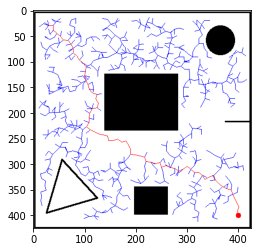

In [131]:
for x1,y1,x2,y2 in path:
    gra[tuple([x1,y1])].append(tuple([x2,y2]))
vis = np.zeros(img.shape)
__ = []
asdf = []
tem = dfs(tuple(t1[0]),tuple(t2[0]),asdf)
tem1 = opt
for i in range(len(tem1) - 1):
    x1 = tem1[i][0]
    y1 = tem1[i][1]
    x2 = tem1[i + 1][0]
    y2 = tem1[i + 1][1]
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0))
plt.imshow(img)

In [ ]:
# python3 combine.py
import cv2
from glob import glob

# parser = argparse.ArgumentParser(description='Converting Frames to Video and Vice Versa')
# parser.add_argument('--in', dest='input', required=True, help = "[--in \path\to\input\directory]")
# parser.add_argument('--out', dest='out', required=True, help="[--out \parh\to\output\directory]")

def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''

    # if not os.path.isdir(input_path):
    #     raise OSError(2, 'No such file or directory', input_path)
    #     return False

    # if not os.path.isdir(output_path):
    #     os.makedirs(output_path)

    image_files = sorted(glob(input_path))
    print(image_files)

    frames = []

    for i in range(len(image_files)):
        # f = f"{input_path}/{i}.png"
        f = f"results/{i}.png" 
        frame = cv2.imread(f)
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

frames_to_video("results/*.png","results/abhinav.mp4", 25)

In [ ]:
def rrt_nonholon(img, t1, t2):
    init_theta=0
    del_t=1
    for i in range(2000):
        available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
        qRand = available[np.random.randint(0,len(available))]
        calc = distance.cdist(t1,[qRand])
        qNear = t1[np.argmin(calc)]

        v, w = [-10, 10], [-math.pi/15, 0, math.pi/15]
        controls = list(itertools.product(v, w))
        max_dist = np.inf
        theta = 0
        qNew=[0,0]

        for crtl in controls:
            v1, w1 = crtl
            temp = [qNear[0] + v1*del_t*math.cos(init_theta + w1*del_t) , qNear[1] + v1*del_t*math.sin(init_theta + w1*del_t)]
            dist = np.linalg.norm(np.array(qRand)-np.array(temp))
            if dist < max_dist:
                qNew = temp
                theta = (init_theta + w1*del_t)
                max_dist = dist
        init_theta=theta
        qNew = np.asarray(qNew,dtype=np.int64)

        if(i%100==0):
            print("i",i)
        if(qNew[0]<0 or qNew[0]>img.shape[1] or qNew[1]<0 or qNew[1]>img.shape[0]):
            continue

        imgcpy = img.copy()
        prevobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
        cv2.line(imgcpy,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))

        newobs = np.sum(np.all(imgcpy == (0,0,0), axis=2))
        if prevobs == newobs:
            cv2.line(img,(int(qNear[0]),int(qNear[1])),(int(qNew[0]),int(qNew[1])),(0,0,255))
            path.append([qNear[0],qNear[1],qNew[0],qNew[1]])
            t1 = np.vstack([t1,qNew])
#         plt.figure()
        plt.imshow(img.astype(np.uint8))
        if np.min(distance.cdist(t1,t2)) < 10 : 
            path.append([qNew[0],qNew[1],t2[0][0],t2[0][1]])
            print("destination reached!")
            return path

i 0
i 100
i 200
i 300
i 400
i 500
i 600
i 700
i 800
i 900
i 1000
i 1100
destination reached!


[[10, 10, 19, 11],
 [19, 11, 18, 20],
 [18, 20, 25, 26],
 [25, 26, 34, 24],
 [34, 24, 42, 28],
 [42, 28, 51, 28],
 [51, 28, 51, 37],
 [51, 37, 48, 46],
 [48, 46, 57, 49],
 [57, 49, 58, 58],
 [58, 58, 60, 67],
 [60, 67, 62, 76],
 [62, 76, 71, 76],
 [71, 76, 80, 74],
 [80, 74, 89, 77],
 [89, 77, 90, 86],
 [90, 86, 87, 95],
 [89, 77, 98, 75],
 [87, 95, 92, 103],
 [92, 103, 101, 107],
 [98, 75, 107, 75],
 [101, 107, 100, 116],
 [100, 116, 100, 125],
 [100, 125, 97, 134],
 [51, 28, 60, 24],
 [107, 75, 116, 74],
 [97, 134, 91, 142],
 [116, 74, 125, 73],
 [125, 73, 134, 76],
 [91, 142, 94, 151],
 [134, 76, 143, 77],
 [125, 73, 126, 63],
 [143, 77, 151, 82],
 [151, 82, 160, 78],
 [160, 78, 166, 85],
 [166, 85, 173, 91],
 [173, 91, 182, 88],
 [182, 88, 185, 97],
 [185, 97, 194, 94],
 [194, 94, 203, 91],
 [94, 151, 99, 159],
 [62, 76, 52, 79],
 [99, 159, 104, 167],
 [104, 167, 109, 175],
 [109, 175, 107, 184],
 [203, 91, 208, 99],
 [208, 99, 213, 107],
 [107, 184, 100, 191],
 [100, 191, 95, 199]

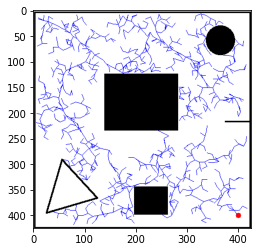

In [ ]:
t1 = [[20,20]]
t2 = [[400,400]]
t1 = np.asarray(t1)
t2 = np.asarray(t2)
img = 255*np.ones((200,200,3))
img = cv2.imread("/content/sq_maze.png")
cv2.circle(img,tuple(t2[0]), 5, (255,0,0), -1)
# cv2.line(img,(25,15),(25,175),(0,0,0),2)
# plt.imshow(img1)
# available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
rrt_nonholon(img,t1,t2)

In [ ]:
img=255*np.ones((5,10,3))
available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
print("avail",available)
for i in range(10):
        available = np.array(np.where((img == [255, 255, 255]).all(axis = 2))).T
        qRand = available[np.random.randint(0,len(available))]
        # qRand = qRand[::-1]
        print(qRand)
        print(img[qRand[0]][qRand[1]])
        cv2.circle(img,(qRand[0],qRand[1]), 1, (0,0,255), -1)
        img[qRand[0]][qRand[1]]==[0,255,0]
        # temp.append(qRand)
        # calc = distance.cdist(t1,[qRand])
        # qNear = t1[np.argmin(calc)]
        # u = qRand - qNear
        # if np.linalg.norm(u) == 0: continue
        # v = u / np.linalg.norm(u)
        # qNew = qNear + ep*v
        # qNew = np.asarray(qNew,dtype=np.int64) 
        # plt.imshow(img)
        if(i%100==0):
            print("i",i)
            # print
        # if(qNew[0]<0 or qNew[0]>img.shape[1] or qNew[1]<0 or qNew[1]>img.shape[0]):
            # continue
plt.imshow(img)
# cv2_imshow(img)